# Learning from Data: Workshop 4 
## Regression and RBF networks

 | Date set     | Hand-in date |
|:------------------|:-----------------------------------|
|6th February 2018  | **12:00 Friday 2nd March 2018** |




This workshop is worth 10% of the total module mark.


Candidate number: ** 650046686 **  

Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Just write comments on the results, etc, using markdown in new cells.

### Submitting the notebooks

Only an electronic submissions is required.  Submit your notebook (the .ipynb file) to electronic copy via the  [electronic hand-in system](http://empslocal.ex.ac.uk/submit/) using the topic <cmd>2018-03-02~ECM3420~Richard Everson~Regression and RBF networks</cmd>.

You should be able to upload the notebook directly from wherever it is on your machine.  If you're not sure where it is, type <code>pwd</code> (print working directory) in a cell to find out.

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 

<font color='blue'>**All of my comments in markdown cells below are written in blue to make my comments clear and stand out from the original instruction text.**</font>

In [1]:
% pylab inline
import wget
figsize(10, 8)

Populating the interactive namespace from numpy and matplotlib


## Linear regression

Get the following little data set which contains one-dimensional data vectors $\mathbf{x}$ and $\mathbf{t}$.  They are stored as two columns, which the following cell splits into two vectors, <code>x</code> and <code>t</code>

In [2]:
import wget
try: 
    X = loadtxt('linreg.txt')
except IOError:
    wget.download('http://empslocal.ex.ac.uk/people/staff/reverson/ECM3420/linreg.txt')
    X = loadtxt('linreg.txt')
x = X[:,0]
t = X[:,1]

  The data were generated
  according to
  \begin{equation*}
    t_n = w_0 + w_1 x_n + \epsilon_n
  \end{equation*}
  where $\epsilon_n$ is Gaussian-distributed noise: $\epsilon_n \sim
  \mathcal{N}(0, \sigma^2)$. Use linear regression to identify the coefficients
  $w_0$ and $w_1$.  Recall that to do this you need to set up a
  *design matrix* $\mathbf{X}$ that contains the features and the dummy
  feature $1$ to go with the bias coefficient $w_0$; thus
  \begin{align*}
    \mathbf{X} =
    \begin{bmatrix}
      1 & x_1\\
      1 & x_2\\
      1 & x_3\\
      \vdots & \vdots\\
      1 & x_N
    \end{bmatrix}
  \end{align*}
  You might find the <code>numpy</code> function <code>ones</code> useful for this. With $\mathbf{X}$ on hand, you can find the coefficients from:
  \begin{align*}
    \mathbf{w} = \mathbf{X}^\dagger \mathbf{t}
  \end{align*}
  where  $\mathbf{t}$ is the vector of the targets and $\mathbf{X}^\dagger$ is the
  pseudo-inverse of $\mathbf{X}$. Use <code>np.linalg.pinv</code> or 
  construct it yourself as $\mathbf{X}^\dagger = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T$ -- see the lecture slides.

In [3]:
def linearRegression(data, targets, toPlot):
    # create matrix with ones
    X = np.vstack((np.ones((data.shape), dtype=int), data)).T
    # get w using pseudo inverse
    w = np.linalg.pinv(X) @ targets
    # get interception point and gradient of regression line
    intercept, gradient = w[0], w[1]
    if (toPlot):
        plot(x, t, 'ro', label="Data")
        plot(x, gradient*x+intercept, 'g', label="Regression line")
        title("Plot of linear regression and scattered data")
        legend(loc=2)
    # return coefficients
    return w

Plot the data and the
  regression line.

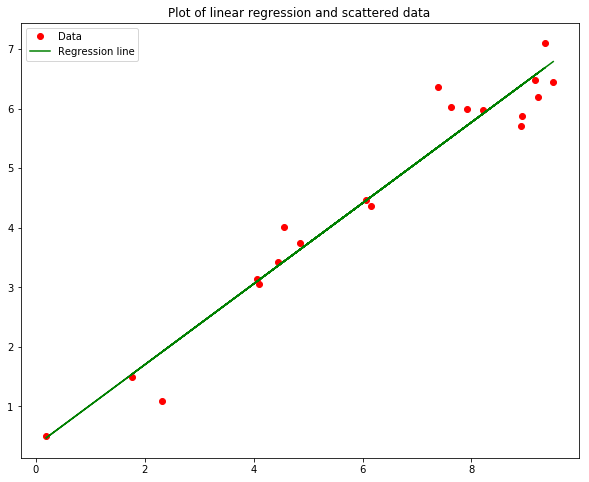

In [4]:
w = linearRegression(x, t, True)

Measure the correlation between the features and targets.

In [5]:
correlation = np.corrcoef(x,t)[0][1] # retrieve only correlation coefficient from the correlation matrix
print("\ncorrelation coefficient:", correlation)


correlation coefficient: 0.975150546405


How does it relate to the coefficients in standardised coordinates?

<font color='blue'> The correlation relates in such way that the coefficients of the original data are the same as the standardised coordinates; they hold same values, which I prove below.
</font><br>

In [6]:
# standardise x
stanX = (x - mean(x)) / std(x)
correlationStan = np.corrcoef(stanX,t)[0][1] # retrieve only correlation coefficient from the correlation matrix
print("\noriginal correlation coefficient:", correlation)
print("\nstandardised correlation coefficient:", correlationStan)


original correlation coefficient: 0.975150546405

standardised correlation coefficient: 0.975150546405


<font color = "blue">If we were to print entire matrix, and not just the correlation coefficients, we would observe rest of values are be equivalent as well (first and last values of matrix are equal to 1).</font>


  Estimate the variance of the noise by finding the variance of the
  differences between your prediction of the targets and the actual
  targets.  Thus if $y_n = w_0 + w_1 x_n$ is the prediction of the $n$th
  target, then you could estimate the variance $\sigma^2$ as:
  \begin{align*}
    \sigma^2 = \frac{1}{N} \sum_{n=1}^N (t_n - y_n)^2
  \end{align*}


In [7]:
def estimateVariance(data, targets):
    # get w coefficients
    w = linearRegression(data, targets, False)
    intercept, gradient = w[0], w[1]
    y = gradient*x+intercept
    s = 0
    # estimate variance
    for i in range(0, len(y)):
        s += (t[i] - y[i]) ** 2
    return (s / len(y))

varEstimate = estimateVariance(x, t)
print("variance estimate:", varEstimate)

variance estimate: 0.180173702915


Does your estimate of the variance make sense in terms of the average deviation of the targets from the prediction?
<br>
<br>
<font color = "blue">
This variance estimate certainly makes sense if we observe the regression line plotted with the targets on the graph above. We see that targets that deviate furthest away from the regression line may be perhaps 0.3 distance away from the prediction (judging purely through observation), but most are very close (regression line nearly passing through some targets). Therefore, the variance estimate makes sense in terms of the average deviation from the targets.
</font>

## Robust linear regression

Standard regression analysis minimises the  squared
error between the regression line and the data, namely:
\begin{equation*}
    E_2(\mathbf{w}) = \sum_{n=1}^N (t_n - y_n(\mathbf{x}; \mathbf{w}) )^2
  \end{equation*}
  where $y_n(\mathbf{w}) = w_0 + w_1 x_n$ and $\mathbf{w} = (w_0, w_1)$. Recall that the
  sum of squares error function $E_2$ comes from the negative log
  likelihood and the assumption that the errors are normally (Gaussian) distributed.

A heavy-tailed distribution that is more appropriate if there are
  occasional large deviations from the systematic trend is the Laplacian
  distribution:
  \begin{align*}
    p(\epsilon_n) = p(t_n \,|\, \mathbf{x}_n, \mathbf{w}) \propto \exp
    \left\{
      - \frac{| \epsilon_n | }{\sigma}
    \right\}
  \end{align*}
Make a plot of the Laplacian distribution (with $\sigma = 1$) and the Gaussian distribution (with mean zero and variance 1) on the same graph to compare their shapes.
  

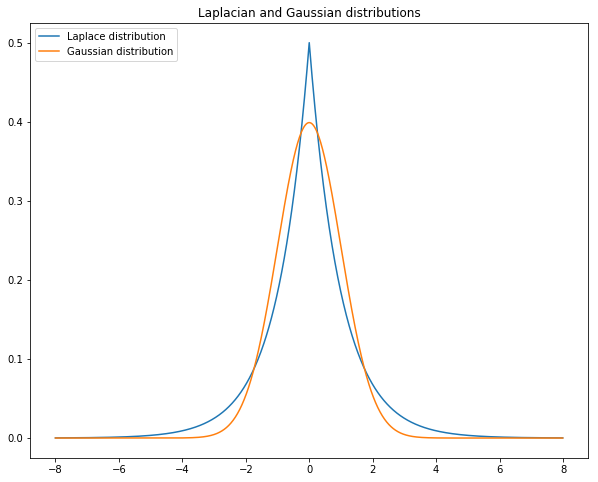

In [8]:
# arbitrary data, sig and mean for comparison

mean, sig = 0, 1

x = np.arange(-8., 8., .01)

pdf = np.exp(-abs(x-mean)/sig)/(2.*sig)

plt.plot(x, pdf, label="Laplace distribution")

g = (1/(sig * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * sig**2)))

title("Laplacian and Gaussian distributions")

plt.plot(x, g, label="Gaussian distribution")

legend(loc=2)

  Explain why the "outliers" -- observations far from the prediction -- might be expected more frequently if $p(\epsilon_n)$ is a Laplacian distribution rather than a Gaussian distribution. 
  <br><br>
  <font color="blue">
  The Laplacian distribution is more appropriate if there are
  occasional large deviations from the systematic trend. However, 
  in cases where data does not contain large deviation from a systematic 
  trend, the Laplacian distribution will observe a larger variance estimate 
  as the prediction will more often deviate further from targets.
  <br><br>
  In fact, there is a theory called the large deviations theory, which specifically conerns
  itself with the notion of exponential decrease of the probability measures for some extreme or tail events,
  and the basic ideas of the theory can be traced to Laplace. This supports our discussion, in that
  we can expect outliers more frequenctly using this heavy-tailed distribution if there are no
  large deviations from the systematic trend of the targets.
  </font>
  

Substitute the above  expression for $p(t_n \,|\, \mathbf{x}_n, \mathbf{w})$ into the
  general expression for an error function $E(\mathbf{w}) = -\sum_{n=1}^N \log
  p(t_n \,|\, \mathbf{x}_n, \mathbf{w}) $ to show that the error function that arises
  from this noise distribution is
  \begin{equation*}
    E_1(\mathbf{w}) = \sum_{n=1}^N |t_n - y_n(\mathbf{x}; \mathbf{w}) |
  \end{equation*}


Please use the LaTeX mark-up to display the derivation.  You may find cutting and pasting from this cell convenient.

\begin{align*}
    p(\epsilon_n) = p(t_n \,|\, \mathbf{x}_n, \mathbf{w}) \propto \exp
    \left\{
      - \frac{| \epsilon_n | }{\sigma}
    \right\}
\end{align*}

<font color = "red">
\begin{align*}
\text{Substitute for } 
\epsilon_n
\text{.} 
\end{align*}
</font>
<font color = "blue">
<br>
\begin{align*}
\epsilon_n = t_n \,|\, \mathbf{x}_n, \mathbf{w}
\end{align*}
<br>
\begin{align*}
    p(t_n \,|\, \mathbf{x}_n, \mathbf{w}) \propto \exp
    \left\{
      - \frac{|(t_n \,|\, \mathbf{x}_n, \mathbf{w}) | }{\sigma}
    \right\}
\end{align*}
<br>
\begin{align*}
    p(t_n \,|\, \mathbf{x}_n, \mathbf{w}) \propto 
    e ^ {
      - \frac{|(t_n \,|\, \mathbf{x}_n, \mathbf{w}) | }{\sigma}
    }
\end{align*}
</font>
<br>
\begin{align*}
 E(\mathbf{w}) = -\sum_{n=1}^N \log
  p(t_n \,|\, \mathbf{x}_n, \mathbf{w}) 
\end{align*}
<font color = "red">
<br>
\begin{align*}
\text{Substitute for } 
 p(t_n \,|\, \mathbf{x}_n, \mathbf{w}) 
\text{.} 
\end{align*}
</font>
<font color = "blue">
<br>
\begin{align*}
 E(\mathbf{w}) = -\sum_{n=1}^N \log
  \text{(} 
  e ^ {
      - \frac{|(t_n \,|\, \mathbf{x}_n, \mathbf{w}) | }{\sigma}
    } 
    \text{)} 
\end{align*}
</font>
<font color = "red">
<br>
\begin{align*}
\text{Following rule for log of exponential.}  
\end{align*}
</font>
<font color = "blue">
<br>
\begin{align*}
 E(\mathbf{w}) = -\sum_{n=1}^N \
 -\frac{|(t_n \,|\, \mathbf{x}_n, \mathbf{w}) | }{\sigma}
 log
  \text{(} e \text{)} 
\end{align*}
<br>
</font>
<font color = "blue">
\begin{align*}
 E(\mathbf{w}) = \sum_{n=1}^N \
 \frac{|(t_n \,|\, \mathbf{x}_n, \mathbf{w}) | }{\sigma}
 log \text{(} e \text{)}  
\end{align*}
</font>
<br>
\begin{equation*}
\rightarrow
    E_1(\mathbf{w}) = \sum_{n=1}^N |t_n - y_n(\mathbf{x}; \mathbf{w}) |
\end{equation*}

The file <code>outlier.txt</code> contains the same data as the one-dimensional linear regression data that you have just been using, but with one target value to be far from the general trend in the data.  You can download it and split it into features and targets with the following.

In [9]:
try: 
    X = loadtxt('outlier.txt')
except IOError:
    wget.download('http://empslocal.ex.ac.uk/~reverson/ECM3420/outlier.txt')
    X = loadtxt('outlier.txt')
x = X[:,0]
t = X[:,1]

Plot $t_n$ versus $x_n$ and find the
  linear regression line for these data using $E_2$. Notice how the
  regression line is grossly affected by the single outlier.


array([-1.30420746,  0.89842779])

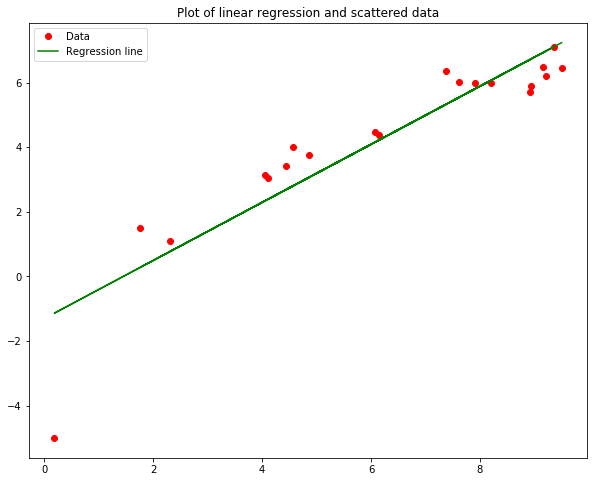

In [10]:
linearRegression(x, t, True)

Write a
  routine to fit a find a straight fitting the data by minimising
  $E_1(\mathbf{w})$.  Note that the pseudo-inverse will not work here.  One
  possibility is to find the minimum error by trying a grid of combinations
  of $w_0$ and $w_1$.  From your plot of the data you should be able to
  estimate appropriate ranges of $w_0$ (the intercept) and $w_1$ (the
  gradient) to search.   If you adopt this approach it is nice to plot a
  contour or <code>pcolor</code> representation of $E_1(\mathbf{w})$ as a function of
  $w_0$ and $w_1$.

Optimization terminated successfully.
         Current function value: 11.598136
         Iterations: 44
         Function evaluations: 81

optimal intercept: 0.278199274401

optimal gradient: 0.69039695182


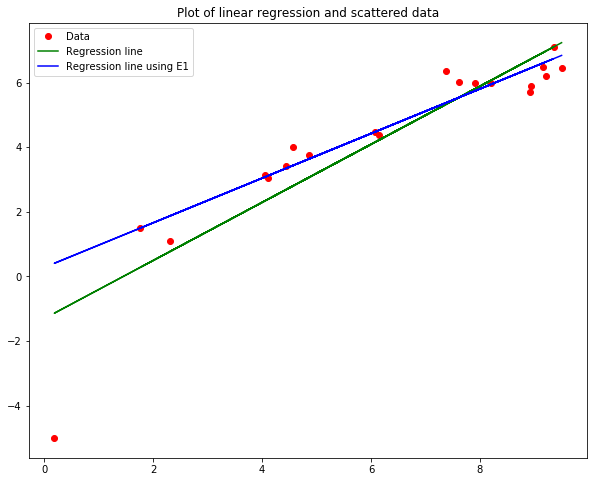

In [11]:
import scipy.optimize

def findE1(initialGuess):
    intercept, gradient = initialGuess
    y = gradient * x + intercept
    E1 = sum(abs(t-y))
    return E1

def optimizeRegression():
    # initial guess based on E2
    initialGuessE2 = linearRegression(x, t, True)
    optimalW = scipy.optimize.fmin(func=findE1, x0=np.array([initialGuessE2[0],initialGuessE2[1]]))
    intercept, gradient = optimalW
    print("\noptimal intercept:", intercept)
    print("\noptimal gradient:", gradient)
    plot(x, gradient*x+intercept, 'b', label="Regression line using E1")
    legend(loc=2)

# I have noted that I continue to use global variables although I use function.
# I chose to leave it as such since it does not change my results and it is low stakes at this point.
# Most importantly it makes it easier for me to work with the optimization function since I
# have to pass and array arguments that will be optimizaed.
optimizeRegression()


   Plot and compare your fitted line with the line derived from the
  squared error (all on the same graph).
  <br><br>
  <font color="blue">
  From observation, it is clear that the my optimization function performs very well. This is obvious as the 
  the variance between the regression line and the targets is clearly overall lower, taking into account that the weight
  given to outliers is lower. This is achieved by testing a range of gradient and intercept values for
  the regression line until the optimal combination is found, which is determined by minimising $E_1(\mathbf{w})$.
  </font>



  Searching a grid like this works well when there are just two
  coefficients to be found, but is computationally very expensive when
  there are many. An alternative is to use a numerical minimiser such as
  <code>scipy.optimize.fmin</code> to locate the minimum -- you might start the search
  at the solution to the $E_2$ problem.  For example, the following cell will find the 2D vector that minimises the banana function, starting at an initial guess <code>x0</code>.

Note how the $E_1$ regression line passes close to the majority of the data because the outlier carries less weight than in the $E_2$ case.

## Radial basis function regression

Here is the demonstration of radial basis functions that I showed in a lecture with a couple of modifications.

The first cell just defines a generator that produces colours in turn, which is useful for plotting later.

In [12]:
from itertools import cycle
colours = cycle("bgrcmykw")
for i in range(10):
    print(next(colours))

b
g
r
c
m
y
k
w
b
g


### Make some data

In [13]:
N = 20
xtr = rand(N)*3
xtr[:N//2] += 4
xtr = sorted(xtr)         # Sorting helps visualise the design matrix later
ttr = sin(xtr) + randn(N)*0.2

xte = rand(N)*3
xte[:N//2] += 4
xte = sorted(xte)         # Sorting helps visualise the design matrix later
tte = sin(xte) + randn(N)*0.2

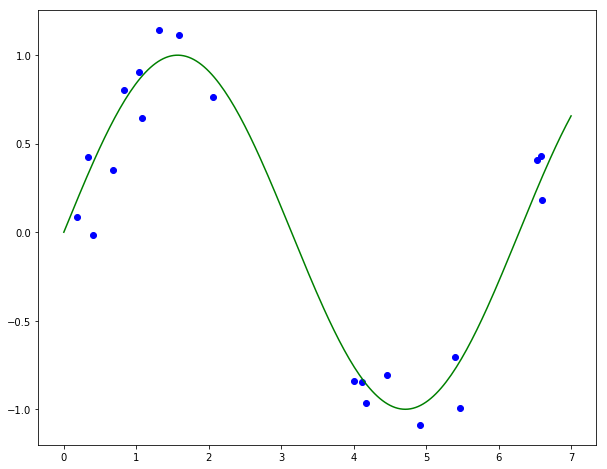

In [14]:
plot(xtr, ttr, 'bo')
xx = linspace(0, 7, 200)
plot(xx, sin(xx), 'g')

### Define radial basis functions

\begin{align*}
\phi(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left\{-x^2/(2\sigma^2)\right\}
\end{align*}

In [15]:
def phi(x, c, sigma=0.1):
    """Radial basis function centred at c with "radius" sigma"""
    return exp(-(x-c)**2/(2*sigma**2))/(sqrt(2*pi)*sigma)

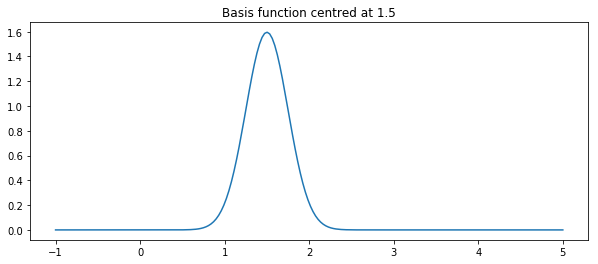

In [16]:
def plot_phi():
    x = linspace(-1, 5, 200)
    c = 1.5
    plot(x, phi(x, c, 0.25))
    title('Basis function centred at %g' % c)
figure(figsize=(10,4))
plot_phi()

### Choose centres and find the activations

In [17]:
# We could choose the centres randomly, but here we'll choose 
# every other one to get an even spread
M = 10
I = np.random.choice(N, M, replace=False)
I = sorted(I)           # Only useful for plotting
print(I)


[0, 2, 3, 4, 7, 8, 12, 16, 18, 19]


Plot the centres $x_m$ and the activations of each of the data points $\phi(x_n-x_m)$.  Note how the activations are large only for the points close to a particular centre.

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  # This is added back by InteractiveShellApp.init_path()


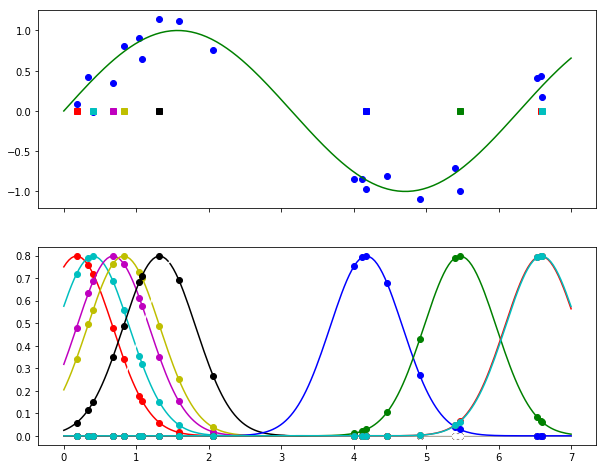

In [18]:
sigma = 0.5     # Choose the width of the basis functions

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(xtr, ttr, 'bo')
ax[0].plot(xx, sin(xx), 'g')


for i in I:
    colour = next(colours)
    ax[1].hold(True)
    ax[1].plot(xx, phi(xx, xtr[i], sigma=sigma), c=colour)
    activation = phi(xtr, xtr[i], sigma=sigma)
    ax[1].plot(xtr, activation, ls='', c=colour, marker='o')
    ax[0].plot(xtr[i], 0.0, marker='s', c=colour)

### Construct a design matrix


\begin{align*}
    \newcommand{\bx}{\mathbf{x}}
    \newcommand{\bX}{\mathbf{X}}
    \newcommand{\bw}{\mathbf{w}}
      \bX =
      \begin{bmatrix}
        1 &\phi_1(\bx_1) & \phi_2(\bx_1) & \ldots & \phi_M(\bx_1)\\
        1& \phi_1(\bx_2) & \phi_2(\bx_2) & \ldots & \phi_M(\bx_2)\\
        1 & \phi_1(\bx_3) & \phi_2(\bx_3) & \ldots & \phi_M(\bx_3)\\
        \vdots & & & & \vdots\\
        1 & \phi_1(\bx_N) & \phi_2(\bx_N) & \ldots & \phi_M(\bx_N)\\
      \end{bmatrix}
    \end{align*}


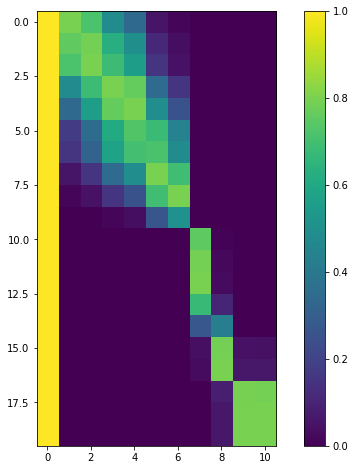

In [19]:
X = zeros((N,M+1))
X[:,0] = 1    # Bias
for m, i in enumerate(I):
    activation = phi(xtr, xtr[i], sigma=sigma)
    X[:,m+1] = activation

imshow(X, interpolation='nearest')
colorbar()

### Solve for the weights using the pseudo-inverse

In [20]:
w = np.linalg.pinv(X) @ ttr

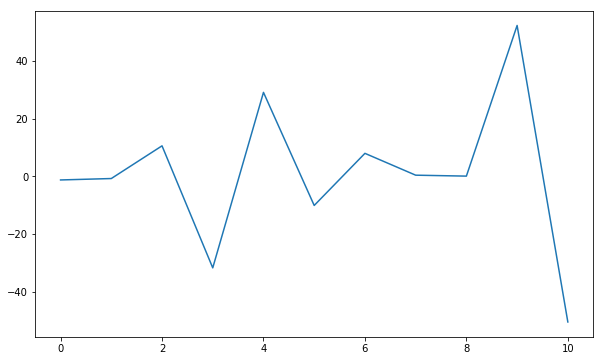

In [21]:
figure(figsize=(10,6))
plot(w)

### Predictions $y(x, \mathbf{w})$

\begin{align*}
   y(\mathbf{x}; \mathbf{w}) &= w_0 + \sum_{m=1}^M w_m \phi(\mathbf{x}-\mathbf{x}_m)\\
   &= w_0 + \sum_{m=1}^M w_m \phi_m(\mathbf{x})
\end{align*}

In [22]:
# Make predictions at lots of points to get a smooth curve
Npred = 200
xtest = linspace(0, 7, Npred)

X = zeros((Npred,M+1))
print(X)
X[:,0] = 1    # Bias
for m, i in enumerate(I):
    activation = phi(xtest, xtr[i], sigma=sigma)
    X[:,m+1] = activation

ytest = X@w


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


(-4, 4)

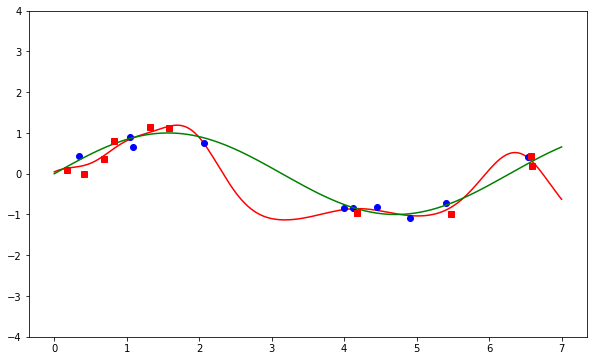

In [23]:
figure(figsize=(10,6))
plot(xtest, ytest, 'r')
plot(xtr, ttr, 'bo')
plot(xx, sin(xx), 'g')

for i in I:
    plot(xtr[i], ttr[i], 'rs')
ylim(ymin=-4, ymax=4)

### Exploring $\sigma$ and $M$

Using the above code as a model write a function

    rbf(xtr, ttr, xte, M, sigma)

that will use the training data <code>xtr</code> and <code>ttr</code> to make predictions for the features <code>xte</code>, using <code>M</code> centres and a width <code>sigma</code> for the radial basis functions.   Your function should return the predictions for <code>xte</code> and the vector of coefficients <code>w</code>.

Use your function to explore the effect of changing $M$ and $\sigma$.  What happens when they are large and small?  Plot both the predictions and the weights.  Notice that $\sigma$ has a smoothing effect when it is large and that poor predictions are made when $\sigma$ is too small.  Also explore what happens when $M$ is large (it can't be larger than the number of training points).  Notice that in this situation the weights can become very large in magnitude and if $\sigma$ is not large enough to provide lots of smoothing then the predictions are very poor where there is not much data.
<br><br>
<font color="blue">
**My observations and deductions are drawn from multiple plots that I have conducted, but I show just 4 different plots below that show exagerated results (from extreme values) for ease of comparison to provide some relevant visuals to aid our discussion on changing the M and sigma values.** 
<br><br>
Plotting different (and extreme) values for M and sigma showed expected results. By changing the sigma value while maintaing the same M we observe poor predictions when $\sigma$ is too small, and we observe a smoothing effect when $\sigma$ is large. If we keep the sigma value consistent and change M, weights can become too large in magnitude. Further, just as expected, if the sigma value is not large enough to compensate for the M value by facilitating a lot of smoothing then the predictions will be poor where there is not much data on the plot.
</font>


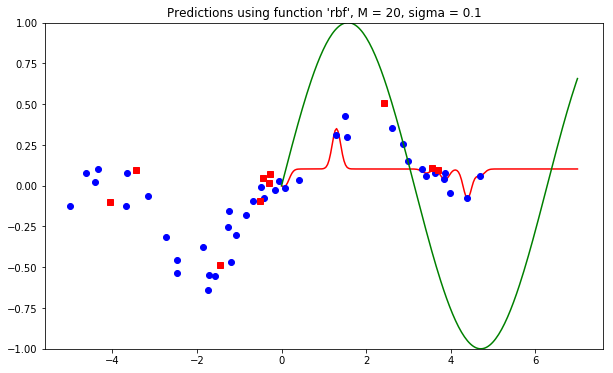

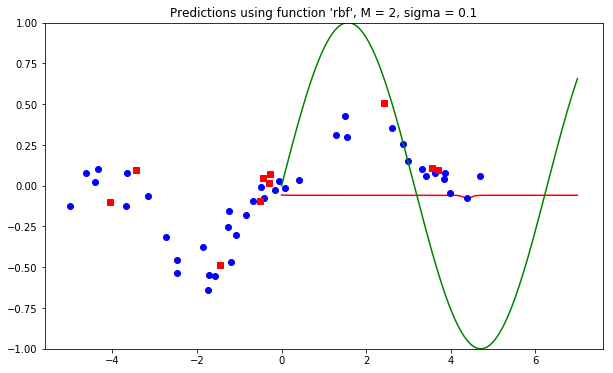

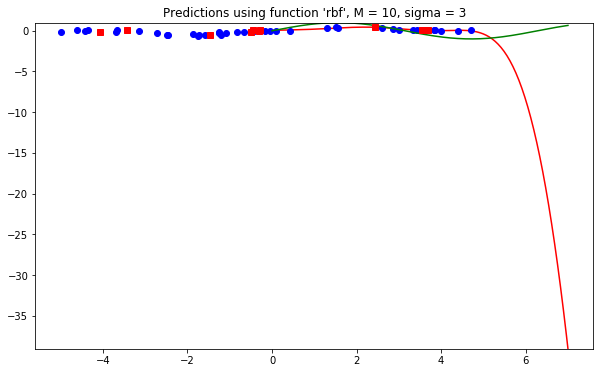

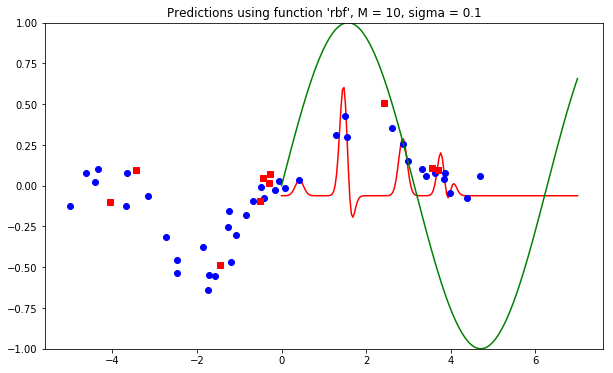

In [28]:
# I use this data test through out
xtest = linspace(0, 7, 200) 
    
def rbf(xtr, ttr, xte, M, sigma):
    
    I = np.random.choice(len(xtr), M, replace=False)
    I = sorted(I)
    
    X = zeros((len(xtr),M+1))
    X[:,0] = 1    # Bias
    for m, i in enumerate(I):
        activation = phi(xtr, xtr[i], sigma)
        X[:,m+1] = activation

    #imshow(X, interpolation='nearest')
    #colorbar()
    
    w = np.linalg.pinv(X) @ ttr

    X = zeros((len(xte),M+1))
    X[:,0] = 1    # Bias
    for m, i in enumerate(I):
        activation = phi(xte, xtr[i], sigma)
        X[:,m+1] = activation
    
    ytest = X @ w
    
    
    return ytest, w

plotFunction(xtr, ttr, xtest, 0, 20, 0.1, True, False, False)
plotFunction(xtr, ttr, xtest, 0, 2, 0.1, True, False, False)
plotFunction(xtr, ttr, xtest, 0, 10, 3, True, False, False)
plotFunction(xtr, ttr, xtest, 0, 10, 0.1, True, False, False)

Choosing a few centres uniformly at random, as we have done here, seems like a good idea because it should ensure that there are a basis functions covering every region of the feature space.  However, if we are unlucky the basis functions all end up close to each other, leaving other parts of the space without any coverage.  You may have noticed this happening as you experimented. Two alternatives to counter this are:

*  Cluster the data and place a basis function at the centre of each cluster.  Here we still have to choose the number of centres to use.

* Put a basis function on *every* point. This could be expensive with lots of data, but we won't need to worry about this.  However, the weights may become very large and the predictions very poor, particularly if $\sigma$ is small.

It would be nice to have a radial basis function regressor that didn't require us to choose $M$ and $\sigma$.  To achieve this we'll put a basis function on every training data point, removing the need to choose $M$.  A reasonable strategy for choosing $\sigma$ is to set it equal to a multiple of the average distance to neighbouring data points. 

Copy your <code>rbf</code> function to make a new function that chooses $M = N$ and $\sigma$ to be, say 10 times, the average distance to the nearest neighbours.  How well does this perform?  Quantify how well it does by calculating the root mean squared error on the test data.  Is 10 times the average nearest neighbour distance a reasonable choice?  

<font color = "blue">
**rbf2 plotted below**
<br><br>It is clear that the new function that equates M to N and $\sigma$ to 10 times the average distance to nearest neighbors performs much better than chosing M and $\sigma$ values at random, which often yields undesirable and extreme results as seen in comparisons made above.
<br><br>
However, I have quantified how well rbf2 performs by calculating the root mean squared error on the test data using my function rmse. Therefore, I hace exactly deduct that, although rbf2 performs fairly well, the returned error is still quite high. Therefore, you could say that 10 times the average nearest neighbour distance choice for the $\sigma$ value is a semi-reseanable choice, but by no means perfect.
</font>

In [ ]:
def rbf2(xtr, ttr, xte):
    
    M = len(xtr)
    
    I = np.random.choice(len(xtr), M, replace=False)
    I = sorted(I)
        
    sigma = 10*np.mean(np.diff(xtr))
    
    X = zeros((len(xtr),M+1))
    X[:,0] = 1    # Bias
    for m, i in enumerate(I):
        activation = phi(xtr, xtr[i], sigma)
        X[:,m+1] = activation

    #imshow(X, interpolation='nearest')
    #colorbar()
    
    w = np.linalg.pinv(X) @ ttr

    X = zeros((len(xte),M+1))
    X[:,0] = 1    # Bias
    for m, i in enumerate(I):
        activation = phi(xte, xtr[i], sigma)
        X[:,m+1] = activation
    
    ytest = X @ w
    
    
    return ytest, w

plotFunction(xtr, ttr, xtest, 0, 0, 0, False, True, False)

def rmse(xtr, ttr, xte):
    predictions, w = rbf2(xtr, ttr, xte)
    y = abs(abs(predictions) - abs(xtest))
    rmsError = np.sqrt(np.mean(y**2))
    return rmsError

rmseError = rmse (xtr, ttr, xtest)
print("root mean squared error for rbf2:", rmseError)

### Overfitting and regularisation

Minimising the mean squared error on the training data can lead to **overfitting**, where the training data is fitted very well, but the test data is fitted poorly: the model does not **generalise** well.  This is because the model weights have been learned so that they fit not only the systematic trends in the data, but also the noise.  This is particularly a problem when there are lots of weights because in this case there is lots of flexibility in the model so that it is possible to fit the noise.

One way to counteract this in RBF regression is to adjust $\sigma$ so that it provides enough smoothing.   However, this limits the expressiveness of the model and a more general way of controlling the flexibility of the model is to prevent the weights from becoming too large.  You will have noticed that when the model is overfitting it tends to have large weights and it is intuitively clear that if the output of the model can only be large or change rapidly with $x$ if the weights are large. 

We can thus **regularise** the model by adding a penalty to the usual error function that makes the error large if the weights are large.  The penalised error function is
\begin{align}
    E(\mathbf{w}) = E_{data}(\mathbf{w}) + \alpha ||\mathbf{w}||^2
\end{align}
where $E_{data}(\mathbf{w}) = E_2(\mathbf{w}) $ is the mean squared error function that we have been using that measures the difference between the data and the output of the model, and $||\mathbf{w}||^2$ is the sum of the squares of the weights.  Thus the usual error function, the first term, is penalised by the second term: if (over)fitting the data would lead to large weights then that also means that the second term and thus the overall error is large.  Consequently minimising this error term arrives at a balance between fitting the data well and having small weights, effectively controlling the smoothness of the model.  The coefficient $\alpha$ controls how important the penalty is.  If $\alpha$ is small, the penalty is unimportant and the weights can be large; if $\alpha$ is large, the penalty means that the weights must be small and the output of the model smooth.  We will have to choose $\alpha$.

This is known as **weight decay regularisation** because it tends to make the weights small. Do some reading about weight decay regularisation; any of the recommended books will do.

A nice feature of WDR for regression is that $E(\mathbf{w})$ is still quadratic and so the optimum weights can be found by linear algebra.   The regularised weights are found as:
\begin{align}
   \newcommand{\bX}{\mathbf{X}}
\mathbf{w} = (\bX^T \bX + \alpha\mathbf{I})^{-1} \bX^T\mathbf{t}
\end{align}
where $\mathbf{X}$ is the design matrix as above and $\mathbf{t}$ is the vector of training targets.  Note that when $\alpha = 0$ we recover the expression for the pseudo-inverse.

### Weight decay regularisation

Copy and modify your RBF regression function to make a function     

    rbfwdr(xtr, ttr, xte, sigma, alpha)

that will use the training data <code>xtr</code> and <code>ttr</code> to make predictions for the features <code>xte</code> using a weight decay regularisation coefficent <code>alpha</code> and RBF width <code>sigma</code>.  As before your function should return the predictions for <code>xte</code> and the vector of coefficients <code>w</code>.

Plot graphs of the predictions and weights with large and small $\alpha$ and verify that it does control the smoothness of the model output.

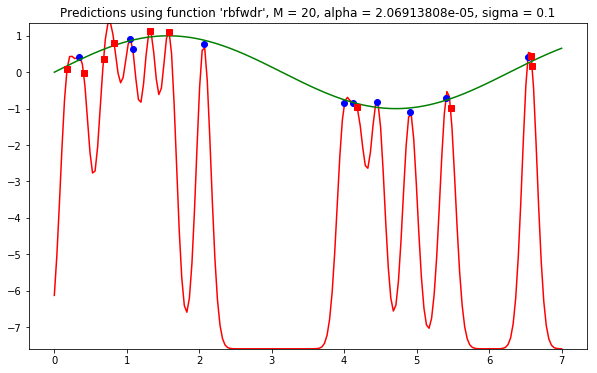

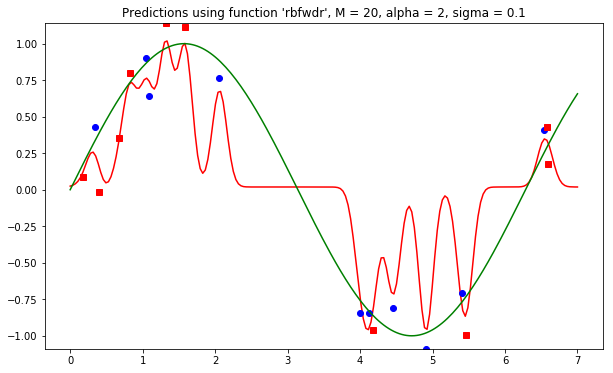

In [25]:
def rbfwdr(xtr, ttr, xte, sigma, alpha):
    
    M = len(xtr)
    
    I = np.random.choice(len(xtr), M, replace=False)
    I = sorted(I)
    
    X = zeros((len(xtr),M+1))
    X[:,0] = 1    # Bias
    for m, i in enumerate(I):
        activation = phi(xtr, xtr[i], sigma)
        X[:,m+1] = activation

    #imshow(X, interpolation='nearest')
    #colorbar()
    
    w = np.linalg.inv((X.T @ X) + (alpha*identity(M+1))) @ X.T @ ttr

    X = zeros((len(xte),M+1))
    X[:,0] = 1    # Bias
    for m, i in enumerate(I):
        activation = phi(xte, xtr[i], sigma)
        X[:,m+1] = activation
    
    ytest = X @ w
    
    
    return ytest, w


def plotFunction(xtr, ttr, xte, alphaVal, mVal, sigmaVal, plotRbf, plotRbf2, plotRbfwdr):
    assert 0 < sum([plotRbf, plotRbf2, plotRbfwdr]) < 2
    results = None
    if plotRbf2:
        ytest, w = rbf2(xtr, ttr, xte)
        results = [ytest, w, "rbf2",  ("M", len(xtr)), ("sigma", 10*np.mean(np.diff(xtr)))]
    if plotRbfwdr:
        ytest, w = rbfwdr(xtr, ttr, xte, sigmaVal, alphaVal);
        results = [ytest, w, "rbfwdr", ("M", len(xtr)), ("alpha", alphaVal), ("sigma", sigmaVal)]
    if plotRbf: 
        ytest, w = rbf(xtr, ttr, xte, mVal, sigmaVal)
        results = [ytest, w, "rbf", ("M", mVal), ("sigma", sigmaVal)]
    
    fig = figure(figsize=(10,6))
    fig = plt.plot(xte, results[0], 'r')
    fig = plt.plot(xtr, ttr, 'bo')
    fig = plt.plot(xx, sin(xx), 'g')
    for i in I:
        fig = plt.plot(xtr[i], ttr[i], 'rs')
    figmin = min([min(results[0]), min(sin(xx)), min(ttr)])
    figmax = max([max(results[0]), max(sin(xx)), max(ttr)])
    fig = plt.ylim(ymin=figmin, ymax=figmax)
    titleStr = "Predictions using function '" + results[2] + "'"
    if len(results) > 3:
        for v in results[3:]:
            strConc =  ", " + v[0] + " = " + str(v[1])
            titleStr += strConc
    fig = plt.title(titleStr)
    fig = plt.show()

# small alpha
plotFunction(xtr, ttr, xtest, 2.06913808e-05 , 0, 0.1, False, False, True)
# large alpha
plotFunction(xtr, ttr, xtest, 2 , 0, 0.1, False, False, True)


### Choosing $\alpha$

Assuming that you have a reasonable value for $\sigma$, it remains to choose $\alpha$ which is done by cross validation.   The data set <code>nonlinreg-train.txt</code> and <code>nonlinreg-test.txt</code> contain features and targets for another one-dimensional, nonlinear regression problem.  Use your <code>rbfwdr</code> function to make predictions for these data and choose $\alpha$ by estimating the generalisation error with cross validation.  You will need to evaluate the training and validation errors for $\alpha$ over a wide range, perhaps $10^{-5}$ to $10^1$; the function <code>logspace</code> is useful for producing equally spaced values: 

    alpha = logspace(-5, 1, 20)
    print(alpha)
    
    [  1.00000000e-05   2.06913808e-05   4.28133240e-05   8.85866790e-05
       1.83298071e-04   3.79269019e-04   7.84759970e-04   1.62377674e-03
       3.35981829e-03   6.95192796e-03   1.43844989e-02   2.97635144e-02
       6.15848211e-02   1.27427499e-01   2.63665090e-01   5.45559478e-01
       1.12883789e+00   2.33572147e+00   4.83293024e+00   1.00000000e+01]

Plot a graph of the training and validation errors versus $\alpha$ (<code>semilogx</code> is useful) and so choose the best $\alpha$ as the one that minimises the validataion error.

You probably won't need to use leave-one-out cross validation, 5-fold cross validation will probably be sufficient.  You can either write your own or you could use the functions in scikit-learn; see <http://scikit-learn.org/stable/modules/cross_validation.html>.  

The following cell loads the data

In [26]:
name = 'nonlinreg-train.txt'
try: 
    X = loadtxt(name)
except:
    wget.download('http://empslocal.ex.ac.uk/~reverson/ECM3420/'+name)
    X = loadtxt(name)
print(X.shape)
xtr = X[:,0]
ttr = X[:,1]

name = 'nonlinreg-test.txt'
try: 
    X = loadtxt(name)
except IOError:
    wget.download('http://empslocal.ex.ac.uk/~reverson/ECM3420/'+name)
    X = loadtxt(name)
print(X.shape)
xte = X[:,0]
tte = X[:,1]


(50, 2)
(500, 2)


optimal alpha: 0.0615848211066


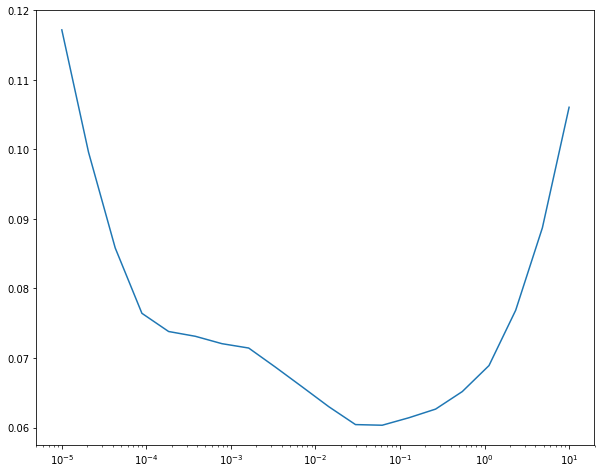

In [27]:
from sklearn.model_selection import KFold

alphaValues = logspace(-5, 1, 20)


def optimalAlpha(xtr, alpha):
    
    valErr = []

    for i in alpha:
        kf = KFold(n_splits=5)
        results = []
        for train, test in kf.split(xtr):
            ytest, w = rbfwdr(xtr[train], ttr[train], xtr[test], 0.5, i)
            differences = abs(abs(ttr[test]) - abs(ytest))
            #print(differences)
            avgDiff = np.mean(differences)
            results.append(avgDiff)
        avgResults = np.mean(results)
        valErr.append(avgResults)
    semilogx(alpha, valErr)
    optimalAlpha = alpha[valErr.index(min(valErr))]
    return optimalAlpha


alphaOpt = optimalAlpha(xtr, alphaValues)
print("optimal alpha:", alphaOpt)                       

Evaluate your final, cross validated model on the actual test data.  There are many more examples of this so you should get an accurate result, but make sure you haven't used the test data during training.

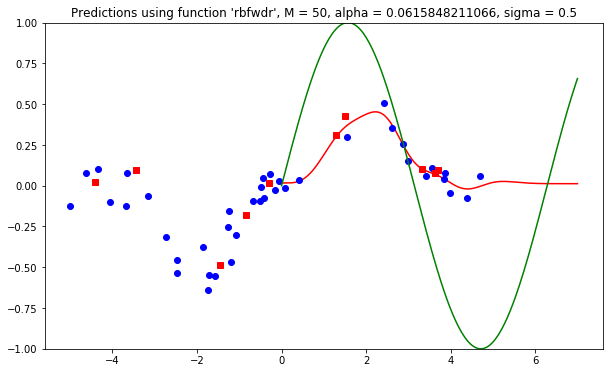

In [30]:
plotFunction(xtr, ttr, xtest, alphaOpt, 10, 0.5, False, False, True)

Upto now we have used a value of $\sigma$ chosen by rule-of-thumb or by a bit of experimentation.  A nicer way to choose it would be by cross validation too.  However, since $\sigma$ and $\alpha$ interact, you really need to find the best value for them both jointly, by searching a grid of possible $(\sigma, \alpha)$ combinations.

Do this for these data and plot (<code>pcolor</code>) the validation error versus 
$\sigma$ and $\alpha$.  Evaluate the performance of your optimised model on the test data.

(There is machinery in sklearn to help with this, but it involves wrapping your RBF network in a class and providing some methods -- see [sklearn.model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).  It's probably easiest just to write generate your own $(\sigma, \alpha)$ pairs using nested loops.)

optimal alpha: 0.000379269019073
optimal sigma: 1.19935394621


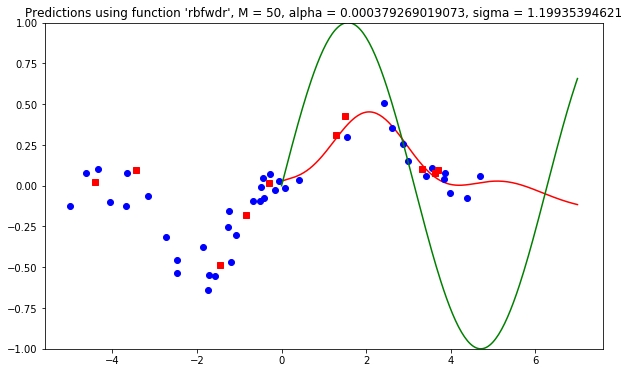

41.5802604743


In [33]:
sigmaValues = logspace(0, 1.5, 20)
# I have plotted with pcolor earlier on in the workshop but have since altered my 
# optimalSigmaAlpha function - now I don't have a (sigma, alpha) array so 
# do not actually use pcolor 

def optimalSigmaAlpha(xtr, sigma, alpha):
    lowestAlphaIndex = []
    valErrOverall = []
    for j in sigma:
        valErr = []
        for i in alpha:
            kf = KFold(n_splits=5)
            results = []
            for train, test in kf.split(xtr):
                ytest, w = rbfwdr(xtr[train], ttr[train], xtr[test], j, i)
                differences = abs(abs(ttr[test]) - abs(ytest))
                avgDiff = np.mean(differences)
                results.append(avgDiff)
            avgResults = np.mean(results)
            valErr.append(avgResults)
        lowestAlphaIndex.append(valErr.index(min(valErr)))
        valErrOverall.append(min(valErr))
    indexLowest = valErrOverall.index(min(valErrOverall))
    sigmaForLowest = sigma[indexLowest]
    alphaForLowest = alpha[lowestAlphaIndex[indexLowest]]  
    return sigmaForLowest, alphaForLowest

optimalSigma, optimalAlpha = optimalSigmaAlpha(xtr, sigmaValues, alphaValues)
print("optimal alpha:", optimalAlpha)
print("optimal sigma:", optimalSigma)  
plotFunction(xtr, ttr, xtest, optimalAlpha, 0, optimalSigma, False, False, True)
ytest, w = rbfwdr(xtr, ttr, xte, optimalSigma, optimalAlpha)
E1 = sum(abs(tte-ytest))
print(E1)

<font color = "blue"> Observing the performance of the model from x > 0 (plotted above), the fit has thus been best than any other throughout the workshop - it is visible that the alpha and sigma have been indeed optimized. The cross validated model works very well with the testing data.